<a href="https://colab.research.google.com/github/KValim/Projetcs/blob/main/Globo/Publicidade_Previsao_Realizado_Angola_(%3F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
#collapse-hide
#Author: Sandeep Pawar
#Version: 1.0
#Date Mar 27, 2020

import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
pd.plotting.register_matplotlib_converters()
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb
from itertools import combinations

import fbprophet as Prophet


#library to use R in Python 
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
 


import warnings
warnings.filterwarnings("ignore")
#np.random.seed(786)
np.random.seed(1658979)

def MAPE(y_true, y_pred): 
    """
    %Error compares true value with predicted value. Lower the better. Use this along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def HWGrid(train, test, seasonal_periods):
    """
    Author: Sandeep Pawar twitter: @PawarBI
    Functions returns a dataframe with parameters of the Holt-Winter's method and corresponding train & test evaluation scores. 
    It also does a quick check of the residuals using Ljung-Box test and Shapiro test for normality. 
    Residuals must be uncorrelated. 
    
    train: (pandas series)
        -  Training data
        
    test: (pandas series)
        -  Test data
    
    Seasonal_periods: int
        - No of seasonas in the time period. e.g. 4 for Quarterly, 12 for Monthly, 52 for Weekly data
        
    """


    trend      = ['add','mul']
    seasonal   = ['add','mul']
    damped     = [False, True]
    use_boxcox = [False, True, 'log']

    params = itertools.product(trend,seasonal,damped,use_boxcox)

    result_df = pd.DataFrame(columns=['Trend', 'Seasonal', 'Damped', 'BoxCox','AICc Train',  
                                      '%MAPE_Train', 'RMSE_Train', '%MAPE_Test', 
                                      'RMSE_Test', "Resid_LJ", "Resid_Norm","Resid_mean" ])
    
    
    for trend,seasonal,damped,use_boxcox in params:
    
            model = ExponentialSmoothing(train, 
                                     trend=trend,
                                     damped=damped,
                                     seasonal=seasonal,
                                     seasonal_periods=seasonal_periods).fit(use_boxcox=None)
    
    
            
            mape1=MAPE(train,model.fittedvalues) 
            rmse1=rmse(train,model.fittedvalues)

            mape2=MAPE(test,model.forecast(len(test))) 
            rmse2=rmse(test,model.forecast(len(test)))

            aicc1 = model.aicc.round(1)

               
    
            lj_p_val = np.mean(ljung(x=model.resid, lags=10)[1])
            norm_p_val =  jb(model.resid)[1]#shapiro(model.resid)[1]
    
            lj = "Uncorrelated" if lj_p_val > 0.05 else "Correlated"
            norm = "Normal" if norm_p_val > 0.05 else "Non-Normal"
            
    
            result_df = result_df.append({'Trend':trend       ,
                              'Seasonal': seasonal            ,
                              'Damped':damped                 ,
                              'BoxCox':use_boxcox             ,
                              '%MAPE_Train':np.round(mape1,2) ,
                              'RMSE_Train':np.round(rmse1,1)  ,
                              'AICc Train':aicc1              ,
                              '%MAPE_Test':np.round(mape2,2)  ,
                              'RMSE_Test':np.round(rmse2,1)   ,
                              'Resid_LJ' :lj                  ,
                              'Resid_Norm':norm               ,
                              'Resid_mean':np.round(model.resid.mean(),1)} , ignore_index=True, sort=False)
    
    
    return result_df.sort_values(by=["RMSE_Test", "%MAPE_Test","RMSE_Train","%MAPE_Train"]).style.format({"%MAPE_Train": "{:20,.2f}%", "%MAPE_Test": "{:20,.2f}%"}).highlight_min(color='lightgreen')
    

def hw_cv(series, seasonal_periods, initial_train_window, test_window):
    
    from statsmodels.tools.eval_measures import rmse
    import warnings
    warnings.filterwarnings("ignore")
    
    """
     Author: Sandeep Pawar
     Date: 4/15/2020
     Ver: 1.0
     
     Returns Rolling and Expanding cross-validation scores (avg rmse), along with model paramters
     for Triple Exponential Smoothing method. Expanding expands the training set each time by adding one observation, 
     while rolling slides the training and test by one observation each time. 
     
     Output shows parameters used and Rolling & Expanding cv scores. Output is in below order:
          1. Trend 2. Seasonal 3. Damped 4. use_boxcox 5. Rolling cv 6. Expanding cv 
     
     Requirements: Pandas, Numpy, Statsmodels, itertools, rmse 
     
     series: Pandas Series
             Time series 
     
     seasonal_periods: int
             No of seasonal periods in a full cycle (e.g. 4 in quarter, 12 in monthly, 52 in weekly data)
             
     initial_train_window: int
             Minimum training set length. Recommended to use minimum 2 * seasonal_periods
     
     test_window: int
             Test set length. Recommended to use equal to forecast horizon
             
     e.g. hw_cv(ts["Sales"], 4, 12, 6 )
          Output: add add False False    R: 41.3   ,E: 39.9

          
     Note: This function can take anywhere from 5-15 min to run full output        
    
     
    
    
    """
    
    
    def expanding_tscv(series,trend,seasonal,seasonal_periods,damped,boxcox,initial_train_window, test_window):
        i =  0
        x = initial_train_window
        t = test_window
        errors_roll=[]

        while (i+x+t) <len(series):
            train_ts=series[:(i+x)].values
            test_ts= series[(i+x):(i+x+t)].values
            model_roll = ExponentialSmoothing(train_ts,
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods,
                                         damped=damped).fit(use_boxcox=None)

            fcast = model_roll.forecast(t)

            error_roll = rmse(test_ts, fcast)

            errors_roll.append(error_roll)

            i=i+1


        return np.mean(errors_roll).round(1)

    def rolling_tscv(series,trend,seasonal,seasonal_periods,damped,boxcox,initial_train_window, test_window):
        i =  0
        x = initial_train_window
        t = test_window
        errors_roll=[]

        while (i+x+t) <len(series):
            train_ts=series[(i):(i+x)].values
            test_ts= series[(i+x):(i+x+t)].values
            model_roll = ExponentialSmoothing(train_ts,
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods,
                                         damped=damped).fit(use_boxcox=None)

            fcast = model_roll.forecast(t)

            error_roll = rmse(test_ts, fcast)

            errors_roll.append(error_roll)

            i=i+1

   
        return np.mean(errors_roll).round(1)
   
    trend      = ['add','mul']
    seasonal   = ['add','mul']
    damped     = [False, True]
    use_boxcox = [False, True, 'log']

    params = itertools.product(trend,seasonal,damped,use_boxcox)

    for trend,seasonal,damped,use_boxcox in params:
        r=rolling_tscv(data["Sales"], trend, seasonal, 4, damped, use_boxcox, 12,4)
        e=expanding_tscv(data["Sales"], trend, seasonal, 4, damped, use_boxcox, 12,4)
        result = print(trend, seasonal, damped, use_boxcox,"   R:", r,"  ,E:", e)
          
    return result

def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, acf_ax, kde_ax


def accuracy(y1,y2):
    
    accuracy_df=pd.DataFrame()
    
    rms_error = np.round(rmse(y1, y2),1)
    
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df


In [ ]:
data = pd.read_excel('database.xlsx', index_col="Date")
data

,Sales
Date,
2017-01-01,126218.061134
2017-02-01,153882.471333
2017-03-01,214537.079458
2017-04-01,195606.675364
2017-05-01,237704.512686
...,...
2021-11-01,23025.810000
2021-12-01,27996.970000
2022-01-01,28919.923180


In [ ]:
#Sales numbers are in thousands, so I am dividing by 1000 to make it easier to work with numbers, especially squared errors
data = pd.read_excel('database.xlsx', parse_dates=True, index_col="Date").div(1_000)

data.index.freq='MS'

data.head()       

,Sales
Date,
2017-01-01,126.218061
2017-02-01,153.882471
2017-03-01,214.537079
2017-04-01,195.606675
2017-05-01,237.704513


In [ ]:
#Split into train and test
train = data.iloc[:-2]
test  = data.iloc[-2:]
#forecast horizon
h = 3
train_length = len(train)

print('train_length:',train_length, '\ntest_length:', len(test) )

#Creating BoxCox transformed train & test to be used later
train_bcox, bcox_lam = boxcox(train["Sales"])
print("BoxCox parameter to linearize the series:", bcox_lam.round(2))
test_bcox = boxcox(test["Sales"], lmbda=bcox_lam)

train_log = np.log(train["Sales"])



train_length: 61 
test_length: 2
BoxCox parameter to linearize the series: 0.64


In [ ]:
#collapse-hide
#Create line chart for Training data. index is reset to use Date column
train_chart=alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='Date', 
    y='Sales', 
    tooltip=['Date', 'Sales'])

#Create Rolling mean. This centered rolling mean 
rolling_mean = alt.Chart(train.reset_index()).mark_trail(
    color='orange',
    size=1
).transform_window(
    rolling_mean='mean(Sales)',
    frame=[-4,4]
).encode(
    x='Date:T',
    y='rolling_mean:Q',
    size='Sales'
)

#Add data labels
text = train_chart.mark_text(
    align='left',
    baseline='top',
    dx=5  # Moves text to right so it doesn't appear on top of the bar
).encode(
    text='Sales:Q'
)

#Add zoom-in/out
scales = alt.selection_interval(bind='scales')

#Combine everything
(train_chart + rolling_mean +text).properties(
    width=1200, 
    title="Realizado & Média Movel ( in '000)").add_selection(
    scales
)

alt.LayerChart(...)

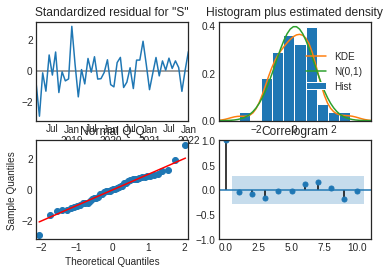

In [ ]:
#Creating SARIMA model in Python using statsmodels

sarima_model=(SARIMAX(endog=train["Sales"], 
               order=(0,1,1),
               seasonal_order=(1,1,0,12),
               trend='c',
               enforce_invertibility=False))

sarima_fit=sarima_model.fit()

start = len(train)
end = len(train) +len(test) -1

sarima_fitted = sarima_fit.fittedvalues

sarima_resid = sarima_fit.resid

py_sarima = sarima_fit.predict(start, end, dynamic=False)

#predictions["py_sarima"] = py_sarima

sarima_fit.plot_diagnostics();



In [ ]:
data[-3:]

,Sales
Date,
2022-01-01,28.919923
2022-02-01,35.120070
2022-03-01,17.329532


In [ ]:
py_sarima2 = sarima_fit.predict(start-13, end+9, dynamic=False)
pd.DataFrame(py_sarima2)

,predicted_mean
2021-01-01,75.971175
2021-02-01,40.604968
2021-03-01,10.731847
2021-04-01,41.177609
2021-05-01,11.180016
2021-06-01,28.600357
2021-07-01,1.780711
2021-08-01,28.159768
2021-09-01,22.573058
2021-10-01,41.190506
